In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from typing import Dict, List, Tuple, Sequence

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [2]:
TARGET = 'gold_price'
N_TARGETS = 1
N_FEATURES = 1

# Data

In [3]:
def create_df_bd():
    business_days = pd.bdate_range(start='2004-01-01', end='2024-07-01')
    df = pd.DataFrame({'timestamp': business_days})
    return df

In [4]:
def df_gold_price():
    df = create_df_bd()
    df1 = pd.read_excel('gold_price.xlsx')
    df1 = df1.rename(columns = {'DATE': 'timestamp','USD': 'gold_price'})
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df = pd.merge(df, df1, on='timestamp', how='left')
    return df

In [1]:
df = create_df_bd()
df_gold = df_gold_price()

NameError: name 'create_df_bd' is not defined

In [10]:
df = pd.merge(df,df_gold, on='timestamp', how='left')
df.set_index('timestamp', inplace=True)
df

,gold_price_x,Unnamed: 2_x,Unnamed: 3_x,Unnamed: 4_x,gold_price_y,Unnamed: 2_y,Unnamed: 3_y,Unnamed: 4_y
timestamp,,,,,,,,
2004-01-01,416.3,NaN,NaN,NaN,416.3,NaN,NaN,NaN
2004-01-02,415.3,NaN,NaN,NaN,415.3,NaN,NaN,NaN
2004-01-05,420.6,NaN,NaN,NaN,420.6,NaN,NaN,NaN
2004-01-06,424.4,NaN,NaN,NaN,424.4,NaN,NaN,NaN
2004-01-07,421.8,NaN,NaN,NaN,421.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-06-25,"2,325.1",NaN,NaN,NaN,"2,325.1",NaN,NaN,NaN
2024-06-26,"2,299.7",NaN,NaN,NaN,"2,299.7",NaN,NaN,NaN
2024-06-27,"2,323.6",NaN,NaN,NaN,"2,323.6",NaN,NaN,NaN


In [7]:
df.fillna(method='bfill', inplace=True)   
df.fillna(method='ffill', inplace=True)

/tmp/ipykernel_170954/50200907.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_170954/50200907.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


# Split the data

In [8]:
INPUT_LENGTH = 10 # business days * 2 weeks
TRAIN_TEST_RATIO = 0.9
OUTPUT_LENGTH = 1

In [9]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int):
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    # print(last_train_idx) # print to debug
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================    
    first_test_idx = last_train_idx - input_length
    # print(first_test_idx) # print to debug
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [10]:
train, test = train_test_split(df, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [11]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int) -> Tuple[pd.DataFrame]:
    """given a fold, it returns one sequence (X_i, y_i) as based on the desired 
    input_length and output_length with the starting point of the sequence being chosen at random based

    Args:
        fold (pd.DataFrame): A single fold
        input_length (int): How long each X_i should be 
        output_length (int): How long each y_i should be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (X_i, y_i)
    """
    pass  # YOUR CODE HERE
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)

In [12]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int):
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [13]:
N_TRAIN = 550 # number_of_sequences_train
N_TEST = 55  # number_of_sequences_test

X_train, y_train = get_X_y(train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

# Model

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Normalization

normalizer = Normalization(input_shape=(INPUT_LENGTH, 1))
normalizer.adapt(X_train)
model = Sequential()
model.add(normalizer)
model.add(LSTM(units=64, activation ='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25,activation ='relu'))
model.add(Dense(units=1, activation = 'linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

/home/alfonsomiguel/.pyenv/versions/lewagon/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train the model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train, epochs=200, 
    batch_size=32, validation_split = 0.2, shuffle = False,
    callbacks=[early_stopping])

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1612771.8750 - mae: 1196.7522 - val_loss: 1566457.5000 - val_mae: 1175.2699
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1612008.0000 - mae: 1196.4662 - val_loss: 1564999.3750 - val_mae: 1174.7743
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1609983.1250 - mae: 1195.7913 - val_loss: 1560553.0000 - val_mae: 1173.2593
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1604364.2500 - mae: 1193.8588 - val_loss: 1553061.3750 - val_mae: 1170.5804
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1596661.6250 - mae: 1191.0831 - val_loss: 1546852.7500 - val_mae: 1168.3275
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1590650.0000 - mae: 1188.9142 - val_loss: 1541632.3750 - val_mae: 1166.4299
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1585623.3750 - mae: 1187.0934 - val_loss: 1536534.0000 - val_mae: 1164.5210
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/s

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10, 1)          │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,596 (482.80 KB)

 Trainable params: 41,197 (160.93 KB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 82,396 (321.86 KB)

In [18]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

array([<AxesSubplot:title={'center':'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot:title={'center':'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

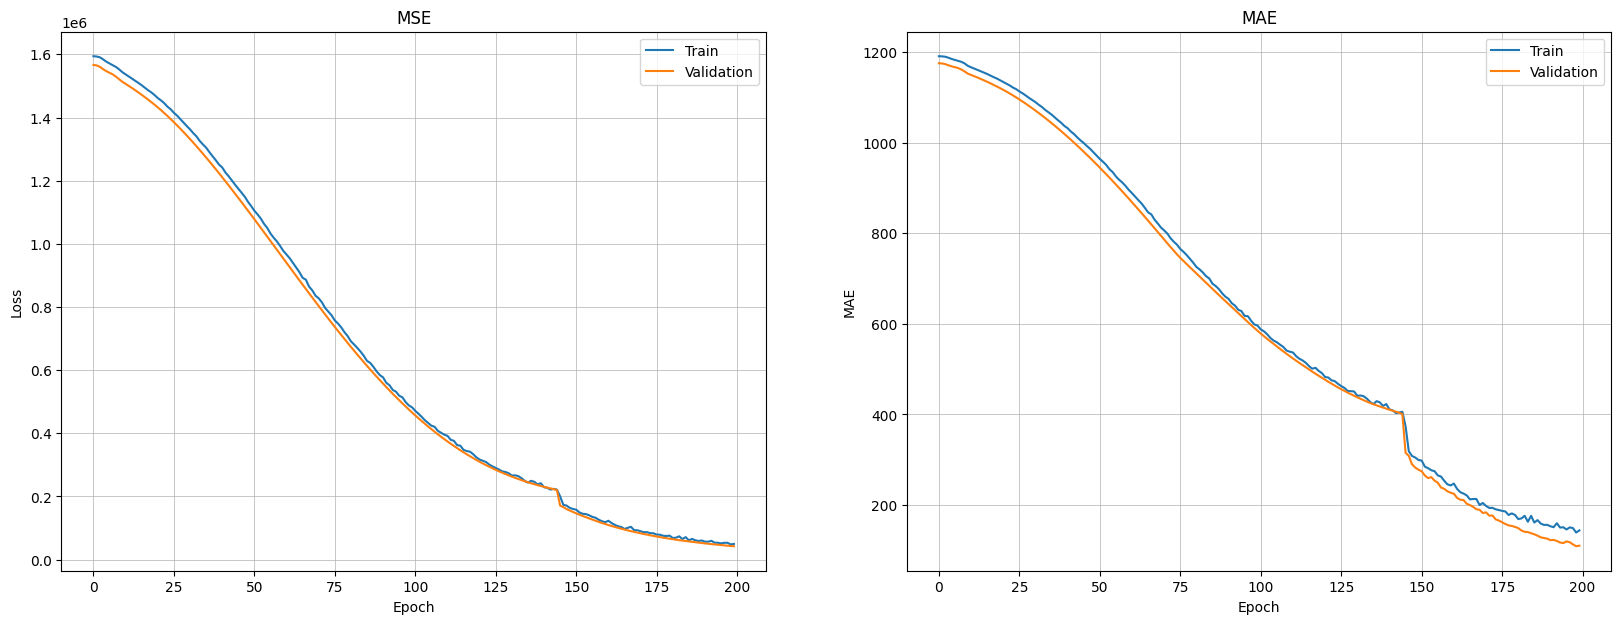

In [19]:
plot_history(history)

In [20]:
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} dollars")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 392848.0625 - mae: 599.5303 
The LSTM MAE on the test set is equal to 586.97 dollars
